We will look at various CSV files in the 'school' folder. Each one of  these csv files contain information on NYC high schools. We will clean the datasets and condense it into one dataframe. The data cleaning process was done in the missions, so we'll quickly repeat the process in this notebook and focus on the data analysis.

# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

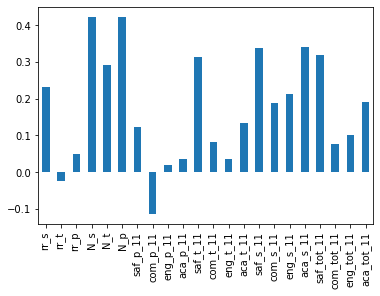

In [11]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Exploring Saftey
Lets investigate the perception of saftey further by creating scatter plots breaking down the differences in correlation between studends and teachers.

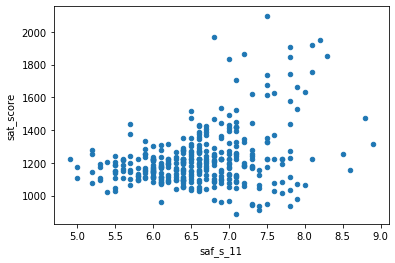

In [12]:
combined.plot.scatter('saf_s_11','sat_score')

There appears to be a slight correlation between SAT scores and safety. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

# Plotting safety

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

#converts to list
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
#generates a scatterplot with the 2 lists as arguments, s=20 for size of points, zorder=2 for dots on top of the map, latlong=True to indicate we are putting in the latitude/longitude
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/opt/anaconda3/share/proj/epsg'

could not get basemap to work 

## Exploring Race
Next we are interested to see if there is a correlation between race and SAT scores.

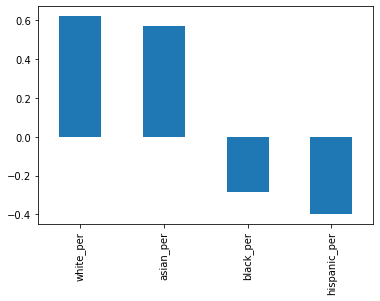

In [18]:
races = [
    'white_per',
    'asian_per',
    'black_per',
    'hispanic_per',
]

correlations[races].plot.bar()

We are seeing positive correlation for whites/asians in SAT scores, negative correlations for blacks/hispanic in SAT scores. However, I wouldn't say any of these correlations are very strong. Let's use a scatter plot for hispanic to see if we can draw any insights.

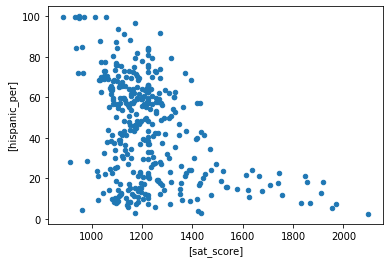

In [19]:
combined.plot.scatter(['sat_score'],['hispanic_per'])

Schools with high amount of hispanics do poorly in the SATs. Schools with low amount of hispanics can do relatively well in the SATs. Let's filter the data down to scools with >95% Hispanics

In [20]:
schools_hisp = combined[combined['hispanic_per'] > 95]
schools_hisp

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,"525 West 50Th Street\nNew York, NY 10019\n(40....",4.000000,3.000000,135.000000,1.083802e+06,1.010790e+09,Clinton ...,40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,"511 West 182Nd Street\nNew York, NY 10033\n(40...",12.000000,10.000000,269.000000,1.063703e+06,1.021550e+09,Washington Heights North ...,40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,"501 West 165Th\nNew York, NY 10032\n(40.838032...",6.792244,22.238227,3760.027701,2.587480e+06,2.515083e+09,0,40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.000000,14.000000,21502.000000,2.008460e+06,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",7.000000,11.000000,409.000000,2.015241e+06,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",9.000000,18.000000,56.000000,2.027459e+06,2.038640e+09,West Farms-Bronx River ...,40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",5.000000,37.000000,1180.000000,3.090738e+06,3.040940e+09,park-cemetery-etc-Brooklyn ...,40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,"45 10 94Th Street\nElmhurst, NY 11373\n(40.743...",4.000000,25.000000,463.000000,4.437166e+06,4.016000e+09,Elmhurst ...,40.743303,-73.870575,24


Let's filter the data to see the schools with low hispanics AND high SAT scores.

In [21]:
schools_hisp_low = combined[(combined['hispanic_per'] < 10) &
                            (combined['sat_score'] > 1800)]
schools_hisp_low

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,"345 Chambers Street\nNew York, NY 10282\n(40.7...",1.0,1.0,31703.0,1084587.0,1.000160e+09,Battery Park City-Lower Manhattan ...,40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",7.0,11.0,409.0,2094706.0,2.032510e+09,Van Cortlandt Village ...,40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",2.0,35.0,33.0,3058752.0,3.020980e+09,Fort Greene ...,40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,"94 50 159 Street\nJamaica, NY 11433\n(40.70099...",12.0,27.0,246.0,4215611.0,4.100990e+09,Jamaica ...,40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,485 Clawson Street Staten Island\nNY 10306\n(4...,2.0,50.0,134.0,5107621.0,5.042440e+09,New Dorp-Midland Beach ...,40.567913,-74.115362,31


Using google searches, we found out that these schools have students who recently immigrated, so most of them are probably still ESL students. It makes sense they do not perform as well in SATs.

Next we'll look correlations between gender and SAT scores

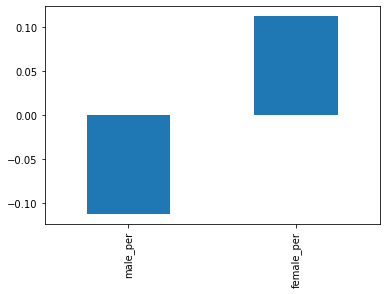

In [22]:
genders =['male_per', 'female_per']
correlations[genders].plot.bar()

Seems like theres very little correlation overall for both sides small positive correlation for females and small negative correlation for males.

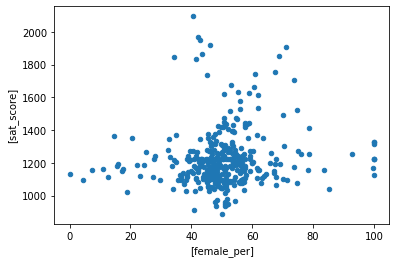

In [23]:
combined.plot.scatter(['female_per'], ['sat_score'])

Scatter plot doesn't show much, data seems very scattered and we are not seeing much correlation between schools with more females and SAT scores.
Let's look at schools with < 60% females and higher than 1700 SAT scores

In [24]:
schools_fem = combined[(combined['female_per'] < 60) & 
                           (combined['sat_score'] > 1700)]
schools_fem

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.000000,2819.000000,...,"345 Chambers Street\nNew York, NY 10282\n(40.7...",1.0,1.0,31703.0,1084587.0,1.000160e+09,Battery Park City-Lower Manhattan ...,40.717746,-74.014049,02
79,05M692,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",101,605.0,654.0,588.0,1847.0,HIGH SCHOOL FOR MATH SCIENCE ENGINEERING @ CCNY,114.000000,124.000000,...,"240 Convent Ave\nNew York, NY 10031\n(40.82112...",9.0,9.0,21703.0,1084085.0,1.019570e+09,Manhattanville ...,40.821123,-73.948845,05
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.000000,2435.000000,...,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",7.0,11.0,409.0,2094706.0,2.032510e+09,Van Cortlandt Village ...,40.877056,-73.889780,10
155,10X696,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,92,636.0,648.0,636.0,1920.0,HIGH SCHOOL OF AMERICAN STUDIES At Lehman College,194.000000,302.000000,...,"2925 Goulden Avenue\nBronx, NY 10468\n(40.8712...",8.0,11.0,409.0,2015222.0,2.032460e+09,Van Cortlandt Village ...,40.871255,-73.897516,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.000000,3692.000000,...,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",2.0,35.0,33.0,3058752.0,3.020980e+09,Fort Greene ...,40.688107,-73.976745,13
198,14K449,"BROOKLYN LATIN SCHOOL, THE",72,586.0,584.0,570.0,1740.0,0,129.028846,197.038462,...,"223 Graham Avenue\nBrooklyn, NY 11206\n(40.709...",1.0,34.0,505.0,3070825.0,3.030250e+09,East Williamsburg ...,40.709900,-73.943660,14
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.000000,338.000000,...,"94 50 159 Street\nJamaica, NY 11433\n(40.70099...",12.0,27.0,246.0,4215611.0,4.100990e+09,Jamaica ...,40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.000000,905.000000,...,485 Clawson Street Staten Island\nNY 10306\n(4...,2.0,50.0,134.0,5107621.0,5.042440e+09,New Dorp-Midland Beach ...,40.567913,-74.115362,31


A google search shows that these schools are heavily STEM focused and have higher entrance requirements, so it makes sense that they have higher SAT scores.

Let's take a look at AP test takers in these schools. It is possible that AP test takers score higher in SATS.

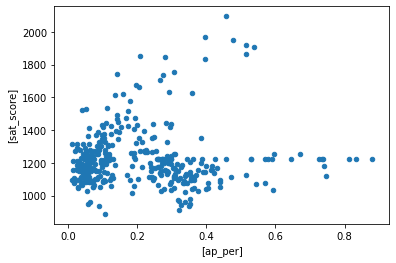

In [25]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

combined.plot.scatter(['ap_per'],['sat_score'])

Schools with low AP test takers tend to score low on SAT as well. Wheras schools with high AP test takers generally score higher. This makes sense because students who enroll in AP classes are generally honor students so they study hard for the SATs as well.

### Learning Summary
Python concepts explored: pandas, matplotlib.pyplot, correlations, regex, basemap, data analysis, string manipulation.

Python functions and methods used: .scatter(), info(), .tolist(), .groupby(), .agg(), .concat(), .apply(), .strip, .merge(), .fillna(), .corr().

The files used for this project can be found in my GitHub repository.